In [ ]:
%%capture
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.4
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
import gdal 

In [ ]:
from tqdm.autonotebook import tqdm 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import rasterio 
import sklearn 
import geopandas as gpd
from gis_utils import raster, ml, shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Function for getting files needed for data generation process from the drive
from os.path import join

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("planetscope" in file) or ("kompsat" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):
                        
                        #get shapefiles from classifications folder
                        for subroot, subdirs, subfiles in os.walk(root):
                            zero = "0.shp"
                            one = "1.shp"
                            
                            #iterating through files in 
                            for subfile in subfiles:
                                if (subfile == zero) or (subfile == one):
                                    #since we will get dupicates
                                    file_list = [join(root,ortho),
                                                 join(subroot,zero),
                                                 join(subroot,one)
                                                ]
                                    if not(file_list in cur):
                                        cur.append(file_list)
                                    



    return cur

In [ ]:
get_filelist()

In [ ]:
def rasterize_zero(shp,img,meta,geometry="geometry",label="label"):
    size = (img.height,img.width)
    out_array = np.zeros(size)
    shapes = ((geom,value) for geom, value in zip(shp[geometry], shp[label]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_array, transform=img.transform)

    return burned

In [ ]:
def rasterize_one(shp,img,meta,geometry="geometry",label="label"):
    size = (img.height,img.width)
    out_array = np.ones(size)
    shapes = ((geom,value) for geom, value in zip(shp[geometry], shp[label]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_array, transform=img.transform)
    burned = 1-burned
    return burned

In [ ]:
from rasterio import features
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image


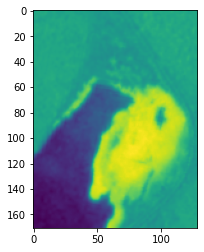

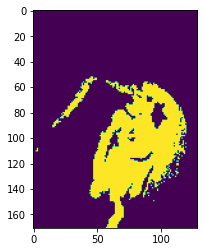

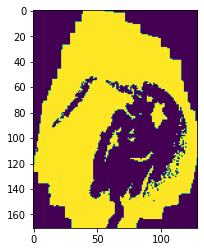

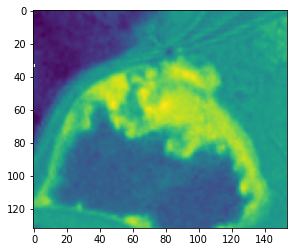

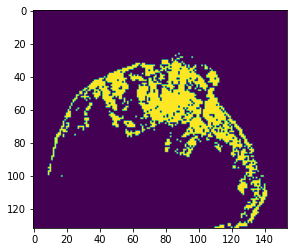

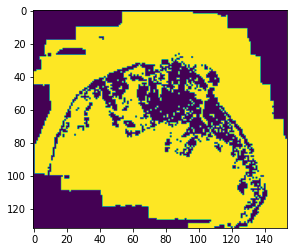

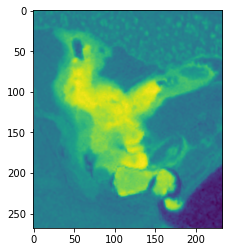

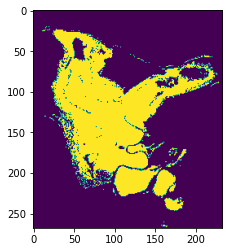

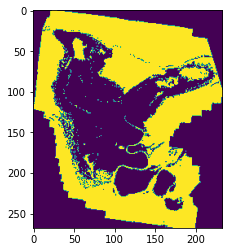

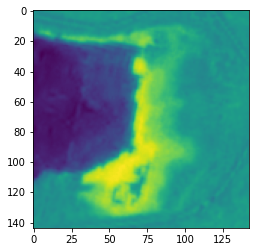

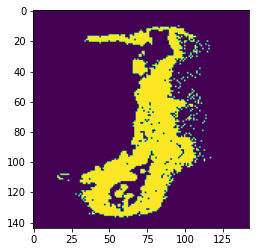

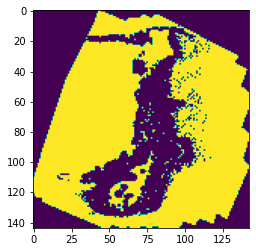

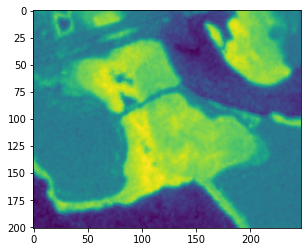

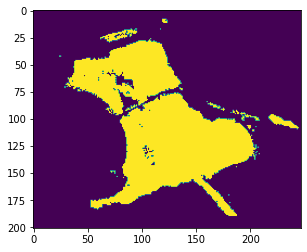

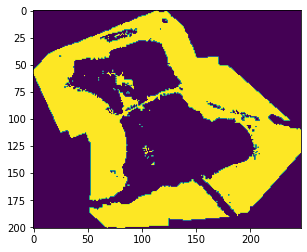

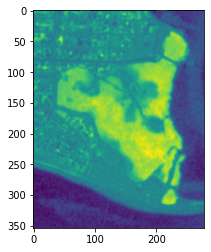

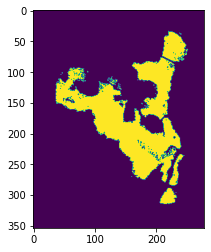

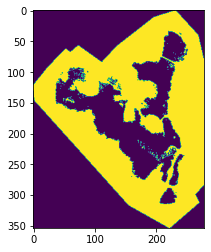

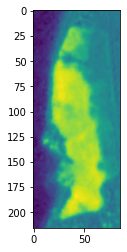

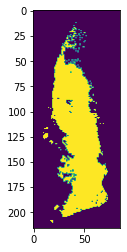

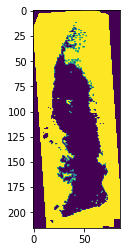

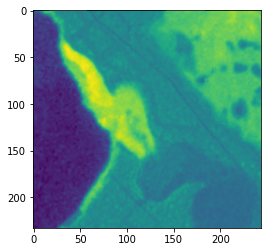

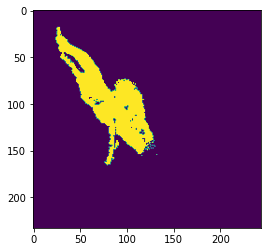

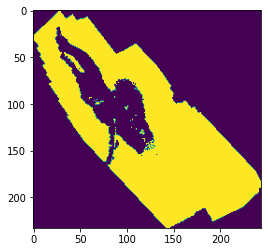

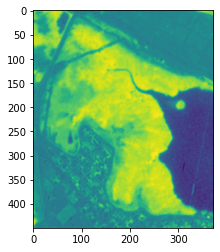

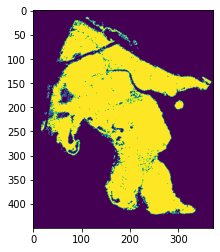

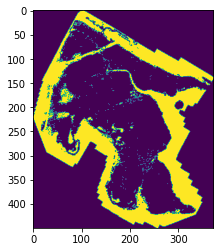

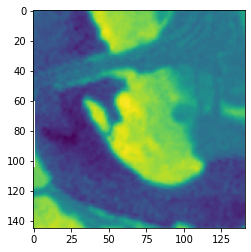

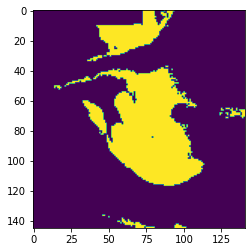

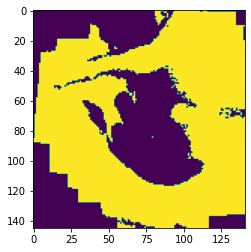

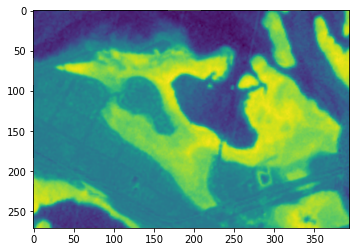

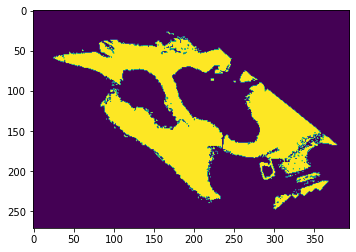

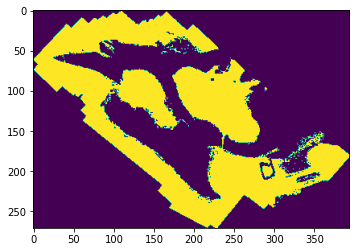

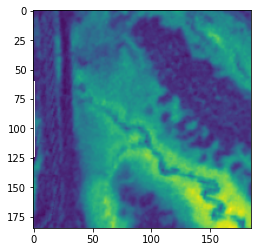

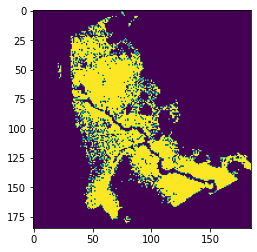

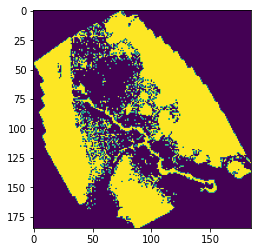

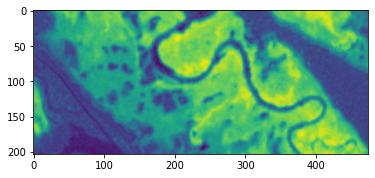

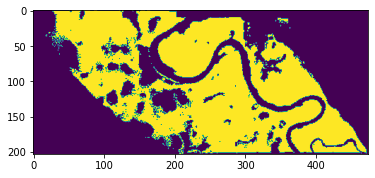

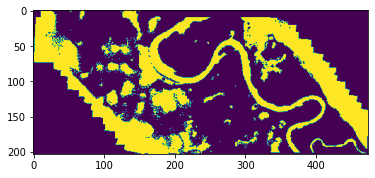

In [ ]:
file_list = get_filelist()

for i, site in enumerate(tqdm(file_list)):
    !cp {"\"" + site[0] + "\""} "planetscope.tif"

    ml.write_ndvi("planetscope.tif")

    img, meta = raster.load_image("planetscope.tif")
    zero_shp = gpd.read_file(site[1])
    one_shp = gpd.read_file(site[2])

    image = reshape_as_image(img.read())
    img_flat = np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))

    zero = rasterize_zero(zero_shp, img, meta)
    one = rasterize_one(one_shp, img, meta)

    show(zero)
    show(one)

    zero_mask = zero.flatten().astype(bool)

    one_mask = one.flatten().astype(bool)

    x_zero = img_flat[zero_mask,:]
    x_one = img_flat[one_mask,:]


    y_zero = zero_mask[zero_mask]
    y_one = ~one_mask[one_mask]


    x_cur = np.concatenate((x_zero,x_one))
    y_cur = np.concatenate((y_zero,y_one)).astype(int)


    if i == 0:
        x = x_cur
        y = y_cur
    else:
        x = np.concatenate((x, x_cur))
        y = np.concatenate((y, y_cur))
        

In [ ]:
from sklearn.preprocessing import StandardScaler

x = np.nan_to_num(x)

scaler = StandardScaler()

x_scaled = scaler.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y)

In [ ]:
from sklearn.metrics import confusion_matrix
def pixel_iou(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    iou = tp / (tp + fn + fp)
    return iou

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()

clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Intersection over Union (IOU): ", pixel_iou(y_test, y_pred))

Accuracy:  0.9194365204012949
Intersection over Union (IOU):  0.8246966104059144


Classifying All Sites

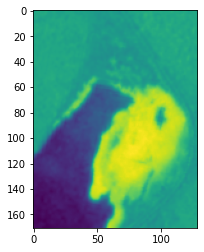

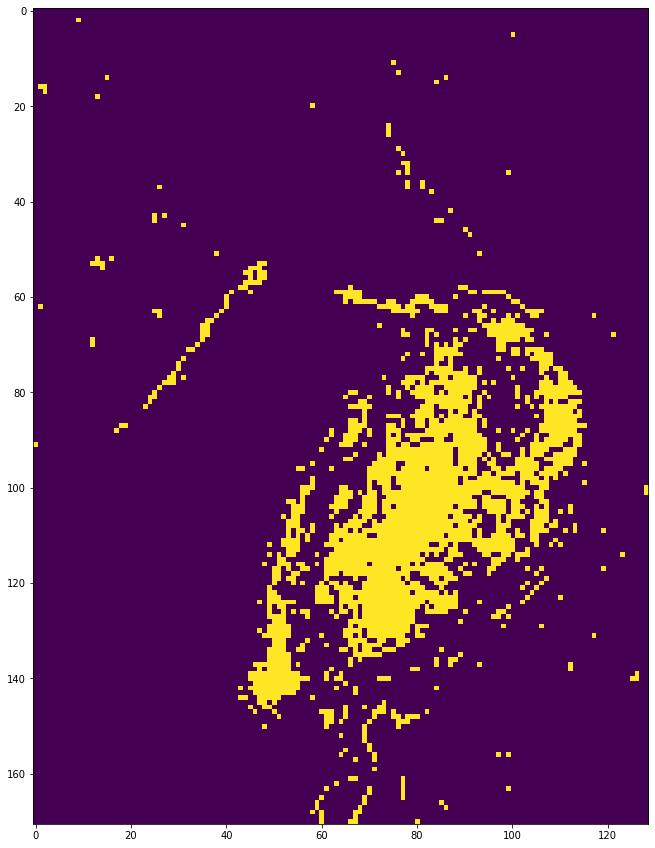

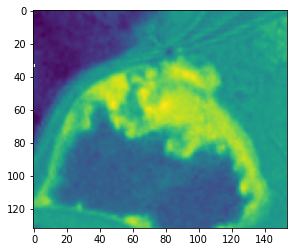

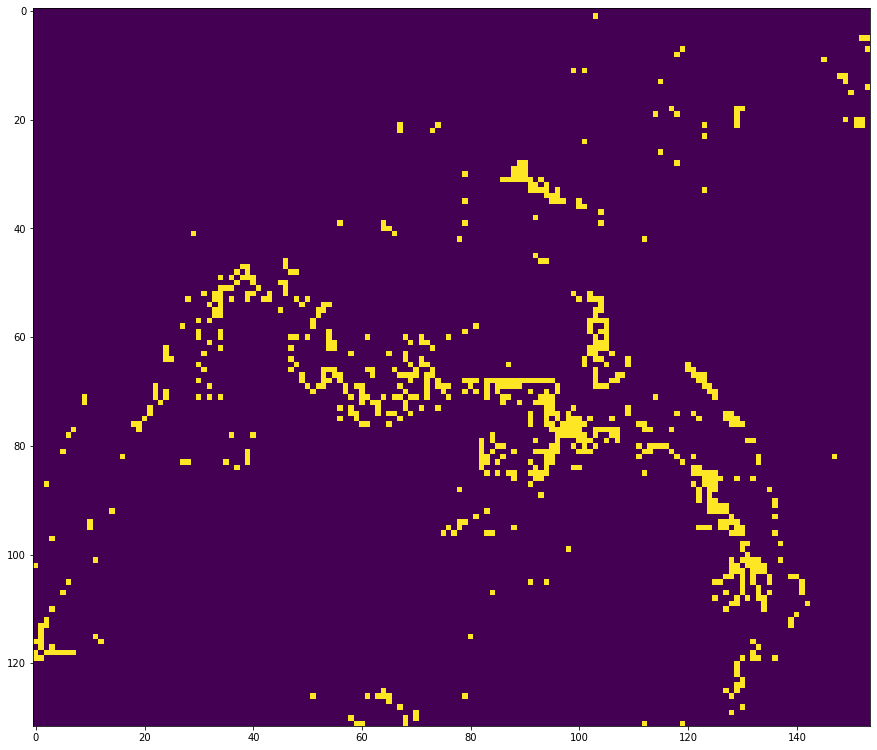

In [ ]:
file_list = get_filelist()

for i, site in enumerate(tqdm(file_list)):
    !cp {"\"" + site[0] + "\""} "planetscope.tif"

    ml.write_ndvi("planetscope.tif")

    img, meta = raster.load_image("planetscope.tif")
    shp = gpd.read_file(site[1])

    image = reshape_as_image(img.read())
    rasterized = rasterize(shp, img, meta)

    x_t = np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))
    x_t = np.nan_to_num(x_t)
    y_t = rasterized.flatten()

    y_predt = clf.predict(x_t)
    label = np.reshape(y_predt, (image.shape[0], image.shape[1]))
    accuracy_score(y_t, y_predt)

    fig, ax = plt.subplots(figsize=(15, 15))

    show(label)